In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [2]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 7GB of memory on the first GPU
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=7000)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)


1 Physical GPUs, 1 Logical GPUs


In [3]:
tf.__version__

'2.0.0-dev20190622'

In [4]:
# To generate GIFs
#!pip install -q imageio

In [5]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display


In [6]:
#(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()


In [7]:

import cv2


images=np.array([cv2.resize((cv2.imread("data/"+tmp, cv2.COLOR_BGR2RGB)),(64, 64))
                                               for tmp in os.listdir("data")])

In [8]:
len(images)

13524

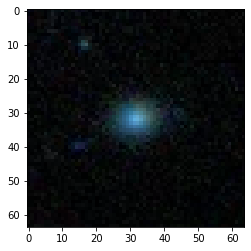

In [173]:
plt.imshow(images[200])

In [52]:
train_images = images

In [53]:
train_images = train_images.reshape(train_images.shape[0], 64, 64, 3).astype('float32')
train_images = (train_images)/ 255 # Normalize the images to [-1, 1]


In [54]:
#from keras.layers import GaussianNoise

In [55]:
train_images

array([[[[0.04705882, 0.05490196, 0.05490196],
         [0.01176471, 0.01960784, 0.01960784],
         [0.00784314, 0.01568628, 0.01568628],
         ...,
         [0.        , 0.        , 0.        ],
         [0.01176471, 0.01960784, 0.01960784],
         [0.        , 0.        , 0.        ]],

        [[0.01176471, 0.01960784, 0.01960784],
         [0.00392157, 0.01176471, 0.01176471],
         [0.01568628, 0.02352941, 0.02352941],
         ...,
         [0.        , 0.00392157, 0.00392157],
         [0.        , 0.00392157, 0.00392157],
         [0.00392157, 0.01568628, 0.01568628]],

        [[0.01176471, 0.01960784, 0.01960784],
         [0.00392157, 0.00784314, 0.00784314],
         [0.00784314, 0.01568628, 0.01568628],
         ...,
         [0.        , 0.00392157, 0.00392157],
         [0.00392157, 0.01176471, 0.01176471],
         [0.02745098, 0.03921569, 0.03921569]],

        ...,

        [[0.09019608, 0.09803922, 0.09803922],
         [0.00784314, 0.01960784, 0.01960784]

In [56]:
BUFFER_SIZE = 20000
BATCH_SIZE = 32


In [57]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)


In [58]:
def make_generator_model():
    model = tf.keras.Sequential()
    
    #model.add(layers.GaussianNoise(0.01, input_shape=(100,)))
    model.add(layers.Dense(4*4*1024, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Reshape((4, 4, 1024)))
 
    assert model.output_shape == (None, 4, 4, 1024) # Note: None is the batch size

    model.add(layers.Conv2DTranspose(512, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 8, 8, 512)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(256, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 16, 16, 256)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 32, 32, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='sigmoid'))
    assert model.output_shape == (None, 64, 64, 3)

    return model


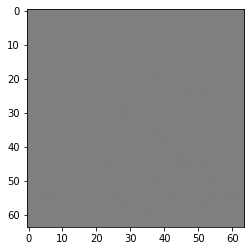

In [59]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0])


In [60]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[64, 64, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model


In [61]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)


tf.Tensor([[-0.07600049]], shape=(1, 1), dtype=float32)


In [62]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)


In [63]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss


In [64]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)


In [65]:
generator_optimizer = tf.keras.optimizers.RMSprop(1e-4)
discriminator_optimizer = tf.keras.optimizers.RMSprop(2e-4)


In [66]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)


In [67]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])


In [68]:
genloss = tf.Variable(0.0)
tf.print(float(genloss.read_value()))
disloss = tf.Variable(0.0)
tf.print(float(disloss.read_value()))

0.0
0.0


In [69]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):

    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
        #tf.print("---Generator loss:", gen_loss)
        #tf.print("Discriminator loss:", disc_loss)
        
        genloss.assign(gen_loss)
        disloss.assign(disc_loss)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
   

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))


In [70]:
def plot_loss(train_loss):
        train_loss = np.asarray(train_loss).transpose()
        epochs = train_loss[0]
        g_losses = train_loss[1]
        d_losses = train_loss[2]

        plt.plot(epochs, g_losses)
        plt.plot(epochs, d_losses)
        plt.legend(['Generator', 'Discriminator'], loc='lower right')
        plt.ylabel('Loss')
        plt.xlabel('Epochs')
        plt.show()

In [71]:
def train(dataset, epochs):
    loss = []
    for epoch in range(epochs):
        start = time.time()

        for image_batch in dataset:
            train_step(image_batch)

        # Produce images for the GIF as we go
        #display.clear_output(wait=True)
        if (epoch + 1) % 10 == 0:
            generate_and_save_images(generator,
                                 epoch + 1,
                                 seed)

        # Save the model every 50 epochs
        if (epoch + 1) % 50 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)
        g_loss = float(genloss.read_value())
        d_loss = float(disloss.read_value())
        loss.append((epoch, g_loss, d_loss))

        tf.print("GL: {0:.3f} | DL: {1:.3f}".format(g_loss, d_loss))

        print('Time for epoch {0:.1f} is {1:.2f} sec'.format(epoch + 1, time.time()-start))

    
    
    # Generate after the final epoch
    #display.clear_output(wait=True)
    generate_and_save_images(generator,
                           epochs,
                           seed)
    
    plot_loss(loss)


In [72]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False).numpy()

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i])
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()


GL: 1.149 | DL: 1.539
Time for epoch 1.0 is 16.58 sec
GL: 1.030 | DL: 1.457
Time for epoch 2.0 is 16.56 sec
GL: 0.647 | DL: 1.378
Time for epoch 3.0 is 16.61 sec
GL: 1.096 | DL: 1.477
Time for epoch 4.0 is 16.66 sec
GL: 0.606 | DL: 1.376
Time for epoch 5.0 is 16.66 sec
GL: 1.153 | DL: 1.922
Time for epoch 6.0 is 16.78 sec
GL: 0.477 | DL: 1.318
Time for epoch 7.0 is 16.81 sec
GL: 0.515 | DL: 1.383
Time for epoch 8.0 is 16.86 sec
GL: 1.136 | DL: 1.545
Time for epoch 9.0 is 16.81 sec


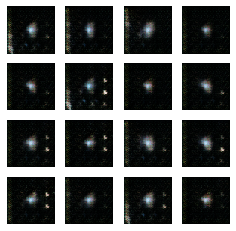

GL: 0.561 | DL: 1.386
Time for epoch 10.0 is 17.27 sec
GL: 1.319 | DL: 1.563
Time for epoch 11.0 is 17.14 sec
GL: 1.142 | DL: 1.367
Time for epoch 12.0 is 16.84 sec
GL: 1.516 | DL: 1.847
Time for epoch 13.0 is 16.89 sec
GL: 1.079 | DL: 1.529
Time for epoch 14.0 is 16.85 sec
GL: 0.805 | DL: 1.167
Time for epoch 15.0 is 16.89 sec
GL: 0.590 | DL: 1.263
Time for epoch 16.0 is 16.87 sec
GL: 1.498 | DL: 1.548
Time for epoch 17.0 is 17.58 sec
GL: 0.822 | DL: 1.196
Time for epoch 18.0 is 17.05 sec
GL: 1.112 | DL: 1.391
Time for epoch 19.0 is 16.86 sec


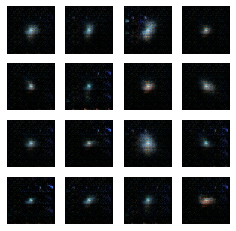

GL: 1.031 | DL: 1.561
Time for epoch 20.0 is 17.36 sec
GL: 1.279 | DL: 1.153
Time for epoch 21.0 is 16.85 sec
GL: 1.414 | DL: 1.698
Time for epoch 22.0 is 16.93 sec
GL: 1.187 | DL: 1.667
Time for epoch 23.0 is 16.89 sec
GL: 1.294 | DL: 1.565
Time for epoch 24.0 is 16.88 sec
GL: 0.409 | DL: 1.539
Time for epoch 25.0 is 16.88 sec
GL: 0.911 | DL: 1.372
Time for epoch 26.0 is 16.89 sec
GL: 0.534 | DL: 1.617
Time for epoch 27.0 is 16.89 sec
GL: 1.225 | DL: 1.835
Time for epoch 28.0 is 16.97 sec
GL: 1.076 | DL: 1.520
Time for epoch 29.0 is 17.32 sec


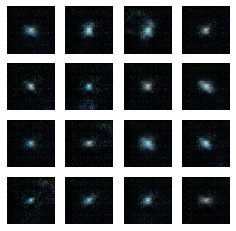

GL: 0.998 | DL: 1.421
Time for epoch 30.0 is 17.85 sec
GL: 0.519 | DL: 1.474
Time for epoch 31.0 is 16.93 sec
GL: 0.549 | DL: 1.310
Time for epoch 32.0 is 16.95 sec
GL: 0.308 | DL: 2.017
Time for epoch 33.0 is 17.22 sec
GL: 0.321 | DL: 2.049
Time for epoch 34.0 is 17.97 sec
GL: 0.878 | DL: 1.192
Time for epoch 35.0 is 18.37 sec
GL: 0.404 | DL: 1.591
Time for epoch 36.0 is 17.47 sec
GL: 0.263 | DL: 2.184
Time for epoch 37.0 is 16.95 sec
GL: 0.453 | DL: 1.471
Time for epoch 38.0 is 16.87 sec
GL: 1.346 | DL: 1.437
Time for epoch 39.0 is 17.18 sec


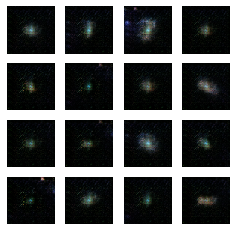

GL: 0.836 | DL: 1.513
Time for epoch 40.0 is 17.97 sec
GL: 1.185 | DL: 1.679
Time for epoch 41.0 is 17.40 sec
GL: 1.105 | DL: 1.631
Time for epoch 42.0 is 16.91 sec
GL: 1.130 | DL: 1.801
Time for epoch 43.0 is 16.93 sec
GL: 0.854 | DL: 1.278
Time for epoch 44.0 is 17.22 sec
GL: 1.259 | DL: 1.435
Time for epoch 45.0 is 16.88 sec
GL: 1.041 | DL: 1.468
Time for epoch 46.0 is 16.88 sec
GL: 0.551 | DL: 1.348
Time for epoch 47.0 is 16.88 sec
GL: 0.581 | DL: 1.340
Time for epoch 48.0 is 16.95 sec
GL: 0.826 | DL: 1.279
Time for epoch 49.0 is 16.89 sec


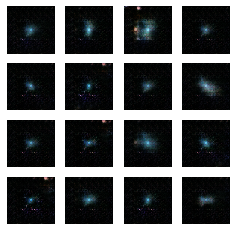

GL: 1.323 | DL: 1.696
Time for epoch 50.0 is 17.58 sec


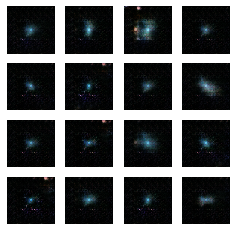

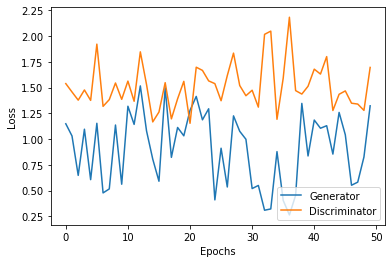

CPU times: user 5min 3s, sys: 24.4 s, total: 5min 27s
Wall time: 14min 13s


In [74]:
%%time
train(train_dataset, EPOCHS)



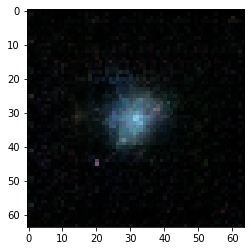

In [170]:
noise = tf.random.normal([1,100]) # shape is 1, 100

random_galaxy = checkpoint.generator(noise, training = False).numpy()[0]
plt.imshow(random_galaxy)

plt.show()


In [148]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))


In [91]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))


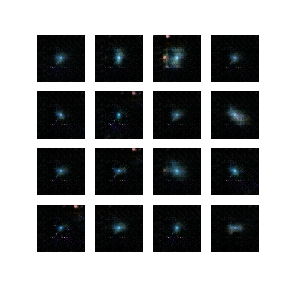

In [92]:
display_image(EPOCHS)


In [93]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 2*(i**0.5)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

import IPython
if IPython.version_info > (6,2,0,''):
  display.Image(filename=anim_file)
